In [1]:
from abc import ABC
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from skimage.io import imread
from skimage.transform import resize
from time import time


DEVICE = torch.device("cuda:0" if
torch.cuda.is_available() else "cpu")

DEVICE

device(type='cuda', index=0)

Loaded 200 images
100 50 50


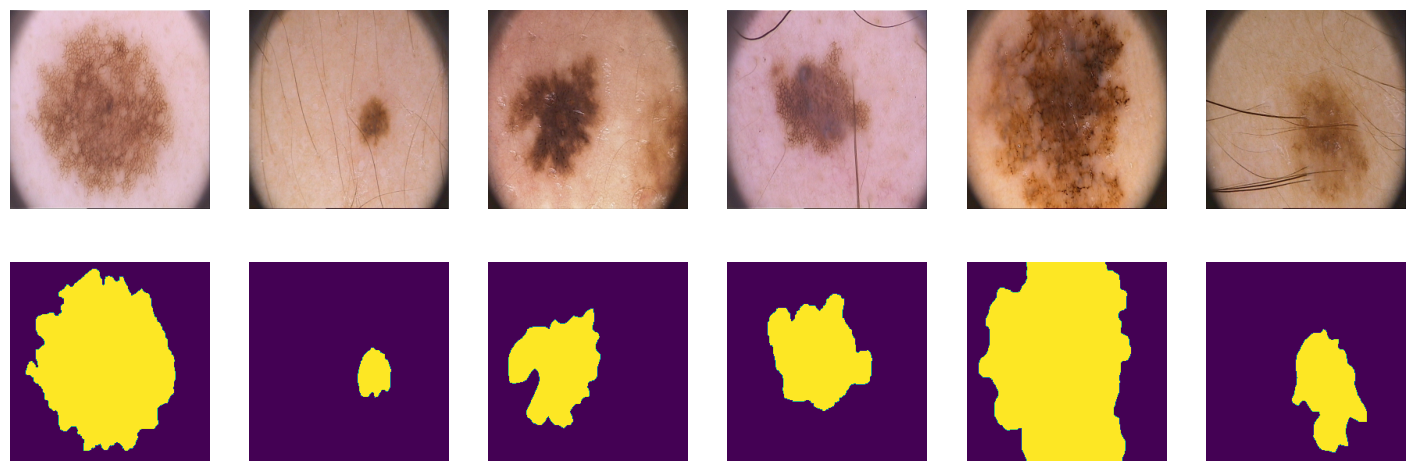

In [2]:
def plot_images():
    plt.figure(figsize=(18, 6))
    for i in range(6):
        plt.subplot(2, 6, i+1)
        plt.axis("off")
        plt.imshow(X[ix[i]])
        plt.subplot(2, 6, i+7)
        plt.axis("off")
        plt.imshow(Y[ix[i]])
    plt.show()

images = []
lesions = []
root = 'PH2Dataset'
for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root,files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root,files[0])))

size = (256, 256)
X = [resize(x, size, mode='constant',anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant',anti_aliasing=False) > 0.5 for y in lesions]

X = np.array(X, np.float32)
Y = np.array(Y, np.float32)

print(f'Loaded {len(X)} images')

len(lesions)

ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

print(len(tr), len(val), len(ts))
plot_images()

In [3]:
batch_size = 12
# noinspection PyTypeChecker
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), batch_size=batch_size, shuffle=True)
# noinspection PyTypeChecker
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])), batch_size=batch_size, shuffle=True)
# noinspection PyTypeChecker
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])), batch_size=batch_size, shuffle=True)


In [4]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True))

def crop_image(input_tensor, target_tensor):
    target_size = target_tensor.size()[2]
    tensor_size = input_tensor.size()[2]
    delta = (tensor_size - target_size) // 2
    return input_tensor[:, :, delta:tensor_size - delta, delta:tensor_size - delta]

class UNet(nn.Module, ABC):
    def __init__(self):
        super().__init__()
        self.conv_down1 = double_conv(3, 64)
        self.conv_down2 = double_conv(64, 128)
        self.conv_down3 = double_conv(128, 256)
        self.conv_down4 = double_conv(256, 512)
        self.conv_down5 = double_conv(512, 1024)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.trans_up1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)
        self.conv_up1 = double_conv(1024, 512)

        self.trans_up2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
        self.conv_up2 = double_conv(512, 256)

        self.trans_up3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        self.conv_up3 = double_conv(256, 128)

        self.trans_up4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        self.conv_up4 = double_conv(128, 64)
        
        self.last_conv = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1)

    def forward(self, image):
        # Encoder part
        x1 = self.conv_down1(image)
        x2 = self.maxpool(x1)
        x3 = self.conv_down2(x2)
        x4 = self.maxpool(x3)
        x5 = self.conv_down3(x4)
        x6 = self.maxpool(x5)
        x7 = self.conv_down4(x6)
        x8 = self.maxpool(x7)
        x9 = self.conv_down5(x8)

        # Decoder part
        x = self.trans_up1(x9)
        y = crop_image(x7, x)
        x = self.conv_up1(torch.cat([x, y], 1))
        x = self.trans_up2(x)
        y = crop_image(x5, x)
        x = self.conv_up2(torch.cat([x, y], 1))
        x = self.trans_up3(x)
        y = crop_image(x3, x)
        x = self.conv_up3(torch.cat([x, y], 1))
        x = self.trans_up4(x)
        y = crop_image(x1, x)
        x = self.conv_up4(torch.cat([x, y], 1))

        out = self.last_conv(x)
        
        return out


In [5]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
 
 outputs = outputs.squeeze(1).byte()
 labels = labels.squeeze(1).byte()
 smooth = 1e-8

 intersection = (outputs & labels).float().sum((1,2))
 union = (outputs | labels).float().sum((1, 2))
 iou = (intersection + smooth) / (union + smooth)
 thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10
 
 return thresholded

In [6]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    x_val, y_val = next(iter(data_val))
    start_time = time()

    for epoch in range(epochs):
        
        avg_loss = 0
        avg_loss2 = 0
        model.train() # train mode

        for X_batch, Y_batch in data_tr:
            inputs = X_batch.to(DEVICE)
            labels = Y_batch.to(DEVICE)
            opt.zero_grad()
            print(1)
            y_pred = model(inputs)
            loss = loss_fn(y_pred, labels)
            loss.backward()
            opt.step()
            avg_loss += loss / len(data_tr)
            model.eval()
            print(1)

        for X_batch2, Y_batch2 in data_val:
            inputs2 = X_batch2.to(DEVICE)
            y_pred2 = model(inputs2).cpu().detach()
            loss2 = loss_fn(y_pred2, Y_batch2)
            avg_loss2 += loss2 / len(data_val)

        train_score = score_model(model, iou_pytorch, data_tr)
        test_score = score_model(model, iou_pytorch, data_val)

        if (epoch+1) % 1 == 0:
            print('Epoch: %d/%d, train loss: %f, test loss: %f, train score: %f, test score: %f' % (epoch+1, epochs, avg_loss, avg_loss2, train_score, test_score))

        if epoch+1 == epochs:
            y_hat = model(x_val.to(DEVICE)).detach().to('cpu')
            show_images(x_val, y_val, y_hat, epoch+1, epochs, avg_loss)

    print('Elapsed time: %s' % np.round((time() - start_time), 1))

In [7]:
def predict(model, data):
    model.eval()
    y_pred = [X_batch for X_batch, _ in data]
    return np.array(y_pred)

def score_model(model, metric, data):
    model.eval()
    scores = 0
    threshold = 0.5

    for X_batch, Y_label in data:
        y_pred = model(X_batch.to(DEVICE))
        y_pred = (y_pred > threshold).float()
        scores += metric(y_pred,Y_label.to(DEVICE)).mean().item()

    return scores/len(data)

def show_images(x_val, y_val, y_hat, epoch, epochs, avg_loss):
    for k in range(6):
        plt.subplot(3, 6, k + 1)
        plt.imshow(np.rollaxis(x_val[k].numpy(), 0, 3),
        cmap='gray')
        plt.title('Image')
        plt.axis('off')
        plt.subplot(3, 6, k + 7)
        plt.imshow(y_val[k, 0], cmap='gray')
        plt.title('Labels')
        plt.axis('off')
        plt.subplot(3, 6, k + 13)
        plt.imshow(np.round(y_hat[k, 0].numpy()),
        cmap='gray')
        plt.title('Predicted')
        plt.axis('off')
    plt.suptitle('%d / %d - loss: %f' % (epoch, epochs,avg_loss))
    plt.show()

In [8]:
max_epochs = 30
model = UNet()
loss_function = nn.BCEWithLogitsLoss()
model.__init__()
model.to(DEVICE)
optim = torch.optim.AdamW(model.parameters(), lr=0.00001)

train(model, optim, loss_function, max_epochs, data_tr,data_val)

1


OutOfMemoryError: CUDA out of memory. Tried to allocate 384.00 MiB (GPU 0; 4.00 GiB total capacity; 2.34 GiB already allocated; 0 bytes free; 3.11 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
final_score = score_model(model, iou_pytorch, data_ts)